# Overview Test Without NaN
Overview from test sets without NaN in it.

## Overview

| Model                              | AUC   | Note | Notebook |
|------------------------------------|-------|------|----------|
| Random Forest (Zero imputed)       | 0.950 |      | 12       |
| Random Forest (Mean imputed)       | 0.944 |      | 12       |
| Random Forest (MissForest imputed) |       |      |          |
| GradientBoosting                   | 0.950 |      | 13       |
| HistGradientBoosting               | 0.968 |      | 12       |
| XGBoost                            | 0.962 |      | 12       |

## Data

In [10]:
from sklearn.model_selection import train_test_split
from util import get_train_dataset, get_features, fix_test, evaluate_no_cv, calculate_auc_and_plot,
    get_columns_starting_with
import numpy as np

df = get_train_dataset()
# df = df.sample(n=1000) # for faster debugging

train, test = train_test_split(df, test_size=0.2, random_state=42)

test.dropna(inplace=True)
x = get_features(train)
y = train['reaction']

x_test = get_features(test, test=True)
x_test = fix_test(x_test, x.columns)
y_test = test['reaction']

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


## Imputations

In [11]:
from sklearn import impute

### Zero

In [12]:
zero_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
x_zero_imputed = zero_imputer.fit_transform(x)
x_test_zero_imputed = zero_imputer.transform(x_test)

### Mean

In [13]:
mean_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
x_mean_imputed = mean_imputer.fit_transform(x)
x_test_mean_imputed = mean_imputer.transform(x_test)

### MissForest
An iterative RF imputation method https://towardsdatascience.com/missforest-the-best-missing-data-imputation-algorithm-4d01182aed3

In [14]:
# Fix neigbors base import

# Thank you AMLoucas from https://gist.github.com/betterdatascience/c455473d7445c0e7e279efe31a896e17 !!
# Whoever is having the issue with ModuleNotFoundError: No module named 'sklearn.neighbors.base'. this is because when importing missingpy it tries to import automatically 'sklearn.neighbors.base' however in the new versions of sklearn it has been renamed to 'sklearn.neighbors._base' so we have to manually import it to work. The code snippet below does the job. You run the snippet before the import
#
# import sys
# import sklearn.neighbors._base
# sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [15]:
# Drop columns that have all rows missing (is required by missforest)
# x_no_empty_columns = x.drop(columns=x.columns[x.isnull().all()])

In [16]:
# from missingpy import MissForest
# miss_forest_imputer = MissForest()
# x_miss_forest_imputed = miss_forest_imputer.fit_transform(x_no_empty_columns)
# x_test_miss_forest_imputed = miss_forest_imputer.transform(x_test)

## Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)

### Zero imputed

In [18]:
evaluate_no_cv(clf, x_zero_imputed, y, x_test_zero_imputed, y_test)

ROC AUC: 0.950


### Mean imputed

In [19]:
evaluate_no_cv(clf, x_mean_imputed, y, x_test_mean_imputed, y_test)

ROC AUC: 0.944


### MissForest imputed

In [20]:
# evaluate_no_cv(clf, x_miss_forest_imputed, y, x_test_miss_forest_imputed, y_test)

## GradientBoosting

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(random_state=0)

In [26]:
evaluate_no_cv(clf, x_zero_imputed, y, x_test_zero_imputed, y_test)

ROC AUC: 0.958


## HistGradientBoosting

In [21]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier(random_state=0)

In [22]:
evaluate_no_cv(clf, x, y, x_test, y_test)

ROC AUC: 0.968


## XGBoost

In [23]:
from xgboost import XGBClassifier

clf = XGBClassifier(random_state=0)

In [24]:
evaluate_no_cv(clf, x, y, x_test, y_test)

ROC AUC: 0.962


In [12]:
from util import evaluate_no_cv, calculate_auc_and_plot
from sklearn.model_selection import train_test_split
from util import get_train_dataset, get_features, fix_test
from sklearn import impute
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

zero_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
mean_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='mean')

models_to_evaluate = [
    {
        'name': 'Random Forest (Zero imputed)',
        'model': RandomForestClassifier(random_state=0),
        'imputer': zero_imputer,
    },
    {
        'name': 'Random Forest (Mean imputed)',
        'model': RandomForestClassifier(random_state=0),
        'imputer': mean_imputer,
    },
    {
        'name': 'HistGradientBoosting',
        'model': HistGradientBoostingClassifier(random_state=0),
    },
    {
        'name': 'XGBoost',
        'model': XGBClassifier(random_state=0),
    },
]

folds = 5

df = get_train_dataset()


# df = df.sample(n=100) # for faster debugging

def get_train_test(df, seed):
    train, test = train_test_split(df, test_size=0.2, random_state=seed)

    test.dropna(inplace=True)
    x = get_features(train)
    y = train['reaction']

    x_test = get_features(test, test=True)
    x_test = fix_test(x_test, x.columns)
    y_test = test['reaction']

    return x, y, x_test, y_test


scores = pd.DataFrame()
for model in models_to_evaluate:
    for seed in range(folds):

        x, y, x_test, y_test = get_train_test(df, seed)

        if 'imputer' in model:
            x = model['imputer'].fit_transform(x)
            # x_test = model['imputer'].transform(x_test)

        auc = evaluate_no_cv(model['model'], x, y, x_test, y_test)
        scores = scores.append({
            'model': model['name'],
            'auc': auc,
        }, ignore_index=True)

scores

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing
C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ROC AUC: 0.944


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing
C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ROC AUC: 0.926


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing
C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ROC AUC: 0.943


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing
C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ROC AUC: 0.934


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing
C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ROC AUC: 0.943


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing
C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ROC AUC: 0.942


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing
C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ROC AUC: 0.928


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing
C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ROC AUC: 0.938


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing
C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ROC AUC: 0.935


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing
C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ROC AUC: 0.938


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.966


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.955


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.958


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.960


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.961


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.960


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.946


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.955


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.955


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.963


,model,auc
0,Random Forest (Zero imputed),0.944350
1,Random Forest (Zero imputed),0.925876
2,Random Forest (Zero imputed),0.942943
3,Random Forest (Zero imputed),0.933994
4,Random Forest (Zero imputed),0.942932
5,Random Forest (Mean imputed),0.942306
6,Random Forest (Mean imputed),0.927782
7,Random Forest (Mean imputed),0.938048
8,Random Forest (Mean imputed),0.934903
9,Random Forest (Mean imputed),0.938083


In [13]:
baseline = scores[(scores['model'] == 'Random Forest (Zero imputed)')]['auc'].mean()
scores["improvement"] = scores["auc"] - baseline
scores

,model,auc,improvement
0,Random Forest (Zero imputed),0.944350,0.006331
1,Random Forest (Zero imputed),0.925876,-0.012143
2,Random Forest (Zero imputed),0.942943,0.004924
3,Random Forest (Zero imputed),0.933994,-0.004025
4,Random Forest (Zero imputed),0.942932,0.004913
5,Random Forest (Mean imputed),0.942306,0.004287
6,Random Forest (Mean imputed),0.927782,-0.010237
7,Random Forest (Mean imputed),0.938048,0.000029
8,Random Forest (Mean imputed),0.934903,-0.003116
9,Random Forest (Mean imputed),0.938083,0.000064


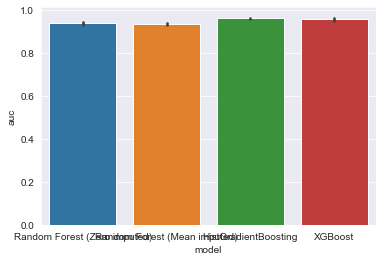

In [14]:
import seaborn as sns

plot = sns.barplot(x="model", y="auc", data=scores, ci="sd")
# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
pass

C:\Users\arnod\AppData\Local\Temp/ipykernel_20120/936369140.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])


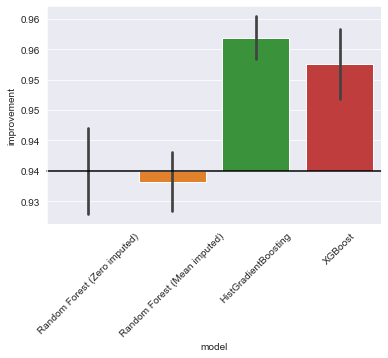

In [15]:
plot = sns.barplot(x="model", y="improvement", data=scores, ci="sd")

plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

plot.axhline(0, color="k", clip_on=False)
y_ticks = plot.get_yticks()
plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])
pass